In [1]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import numpy as np

from IPython.display import HTML
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [2]:
events_data= pd.read_csv('/Users/tony_builder/tony. Личное/IT/Mashine Learning/event_data_train.csv')
events_data

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
...,...,...,...,...
3480698,33375,1526772685,viewed,11677
3480699,32815,1526772750,viewed,5198
3480700,32815,1526772750,discovered,5198
3480701,32815,1526772750,passed,5198


In [3]:
min_max_user_time = events_data.groupby('user_id').agg({'timestamp': 'min'}) \
                            .rename(columns={'timestamp': 'min_timestamp'}) \
                            .reset_index()

min_max_user_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


In [4]:
data_time_filtered = pd.merge(events_data, min_max_user_time, on='user_id', how='outer')

data_time_filtered

,step_id,timestamp,action,user_id,min_timestamp
0,32815,1434340848,viewed,17632,1434340848
1,32815,1434340848,passed,17632,1434340848
2,32815,1434340848,discovered,17632,1434340848
3,32811,1434340895,discovered,17632,1434340848
4,32811,1434340895,viewed,17632,1434340848
...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,1526762664
3480699,32814,1526762783,passed,943,1526762664
3480700,32815,1526772750,viewed,5198,1526772750
3480701,32815,1526772750,discovered,5198,1526772750


In [5]:
learning_time_threshold = 2 * 24 * 60 * 60
data_time_filtered = data_time_filtered.query("timestamp <= min_timestamp + @learning_time_threshold")
data_time_filtered

,step_id,timestamp,action,user_id,min_timestamp
0,32815,1434340848,viewed,17632,1434340848
1,32815,1434340848,passed,17632,1434340848
2,32815,1434340848,discovered,17632,1434340848
3,32811,1434340895,discovered,17632,1434340848
4,32811,1434340895,viewed,17632,1434340848
...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,1526762664
3480699,32814,1526762783,passed,943,1526762664
3480700,32815,1526772750,viewed,5198,1526772750
3480701,32815,1526772750,discovered,5198,1526772750


In [6]:
events_actions_2days = data_time_filtered.pivot_table(index='user_id', 
                        columns='action',                   # здесь назначили имена колонок
                        values='step_id',                   # здесь сообщили откуда взять значения для заполнения
                        aggfunc='count',                    # здесь сказали что делать с этими значениями
                        fill_value=0)                       # здесь сказали, что делать с отсутствующими значениями
                        
events_actions_2days.reset_index()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,2,2,0,2
19230,26793,1,0,1,1
19231,26794,50,50,24,90
19232,26797,10,10,2,10


In [7]:
submissions_data = pd.read_csv('/Users/tony_builder/tony. Личное/IT/Mashine Learning/submissions_data_train.csv')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data['day'] = submissions_data.date.dt.date

users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_scores['score_more_40'] = users_scores.correct > 40

users_scores.score_more_40=  users_scores.score_more_40.map(int)

users_scores

submission_status,user_id,correct,wrong,score_more_40
0,2,2,0,0
1,3,29,23,0
2,5,2,2,0
3,8,9,21,0
4,14,0,1,0
...,...,...,...,...
9935,26787,3,0,0
9936,26790,1,0,0
9937,26794,33,9,0
9938,26797,2,0,0


Воспользуемся функцией подчистки данных (фильтрация действий пользователя за первые два дня)

In [8]:
def time_filter(data, days=2):
    
    """Фильтрация данных до порогового значения"""
    
    # создаем таблицу с первым и последним действием юзера
    min_max_user_time = data.groupby('user_id').agg({'timestamp': 'min'}) \
                            .rename(columns={'timestamp': 'min_timestamp'}) \
                            .reset_index()
    
    data_time_filtered = pd.merge(data, min_max_user_time, on='user_id', how='outer')
    
    # отбираем те записи, которые не позднее двух дней с начала учебы
    learning_time_threshold = days * 24 * 60 * 60
    data_time_filtered = data_time_filtered.query("timestamp <= min_timestamp + @learning_time_threshold")
    
    assert data_time_filtered.user_id.nunique() == data.user_id.nunique()
    
    return data_time_filtered.drop(['min_timestamp'], axis=1)

Возьмем количество решенных пользователем задач за первые дня:
- уберем все события, выходящие за первые два дня
- переформатируем в pivot-table

In [9]:
temp_df = time_filter(submissions_data)

users_score_2days = temp_df.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

users_score_2days

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,24,7
9938,26797,2,0


Здесь в конце концов формируем тренировочный датасэт:
1) мерджим два датасэта:
- все действия пользователя за ДВА ДНЯ
- факт набора/ненабора 40 баллов за весь курс (1/0)

2) удаляем столбцы, отвечающие за правильные/неправильные ответы (они отвечали ЗА ВЕСЬ период обучения)

3) снова мерджим сюда данные с правильными/неправильными решениями но уже за ДВА первых ДНЯ

3) удаляем все пустые значения, приводим все данные в целочисленные значения
3) убираем номер пользователя в индексы 

In [10]:
train_data_temp = events_actions_2days.merge(users_scores.drop(['correct', 'wrong'], axis =1), 
                                        on='user_id', how='outer')

train_data = train_data_temp.merge(users_score_2days, on='user_id', how='outer')

train_data =  train_data.fillna(0).applymap(int)

train_data = train_data.set_index('user_id')

train_data

,discovered,passed,started_attempt,viewed,score_more_40,correct,wrong
user_id,,,,,,,
1,1,0,0,1,0,0,0
2,9,9,2,9,0,2,0
3,15,15,4,20,0,4,4
5,1,1,0,1,0,2,2
7,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...
26790,2,2,0,2,0,1,0
26793,1,0,1,1,0,0,0
26794,50,50,24,90,0,24,7


In [11]:
X = train_data.drop('score_more_40', axis=1)
y = train_data.score_more_40

In [12]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.15, random_state=42)

In [13]:
clf = RandomForestClassifier(random_state=42)

parametrs = {'n_estimators': range(10,120,20), 'max_depth': range(2,8), 
             'min_samples_leaf': range(1,12,5), 
             'criterion':['gini', 'entropy'] , 
             'min_samples_split': range(2,10,4)}

# grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

# grid_search_cv_clf.fit(X_train, y_train)

In [14]:
# grid_search_cv_clf.best_params_

best_params: {'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 70}

In [15]:
# best_clf = grid_search_cv_clf.best_estimator_

In [16]:
best_clf = RandomForestClassifier(criterion='gini', max_depth=7, min_samples_leaf=6, min_samples_split=2, n_estimators=70)

best_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=6, n_estimators=70)

Посчитаем метрики. точность модели довольно низкая!

In [17]:
y_predicted = best_clf.predict(X_test)

print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, y_predicted), 3)}')
print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, y_predicted), 3)}')
print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, y_predicted), 3)}')
print(f'- f1_score  (соотношение точности и полноты) модели равна {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy  (общая точность) модели равна 0.903
- Precision(точность с учетом ложных срабатываний) модели равна 0.535
- Recall    (полнота верных срабатываний) модели равна 0.133
- f1_score  (соотношение точности и полноты) модели равна 0.213


Сделаем таблицу вероятностей набора/ ненабора 40 баллов для тестовой выборки

In [18]:
y_pred_probability = best_clf.predict_proba(X_test) 

prob_scores_40_df = pd.DataFrame(y_pred_probability).rename(columns = {0: 'wont_score', 1: 'will_score'})

prob_scores_40_df

,wont_score,will_score
0,0.964201,0.035799
1,0.978868,0.021132
2,0.808906,0.191094
3,0.999025,0.000975
4,0.999860,0.000140
...,...,...
2881,0.996114,0.003886
2882,0.997606,0.002394
2883,0.894963,0.105037
2884,0.997606,0.002394


Построим ROC-кривую 

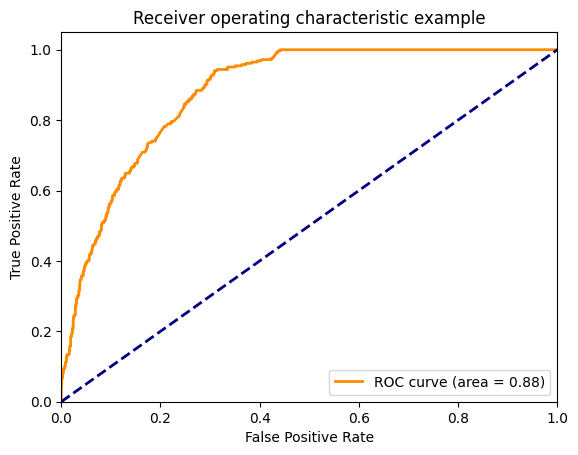

In [19]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probability[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Выдернем значение Roc-кривой

In [20]:
roc_score = roc_auc_score(y_test, y_pred_probability[:, 1])
print('roc на test', roc_score)

roc на test 0.881146252790762


Воспользуемся кроссвалидацией для повышения качества модели

In [21]:
new_clf = RandomForestClassifier(**best_clf.get_params())

cv_scores = cross_val_score(new_clf, X, y, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.8884658885464839


        А теперь то, ради чего это все затевалось собственно: предсказание вероятностей для данных после 20 мая 2018

In [26]:
events = pd.read_csv('/Users/tony_builder/Downloads/events_data_test (1).csv')

sub_df = pd.read_csv('/Users/tony_builder/Downloads/submission_data_test (1).csv')

events_actions = events.pivot_table(index='user_id', 
                        columns='action',                   # здесь назначили имена колонок
                        values='step_id',                   # здесь сообщили откуда взять значения для заполнения
                        aggfunc='count',                    # здесь сказали что делать с этими значениями
                        fill_value=0)                       # здесь сказали, что делать с отсутствующими значениями
                        
submissions_moves = sub_df.pivot_table(index='user_id', 
                        columns='submission_status',                   # здесь назначили имена колонок
                        values='step_id',                   # здесь сообщили откуда взять значения для заполнения
                        aggfunc='count',                    # здесь сказали что делать с этими значениями
                        fill_value=0)                       # здесь сказали, что делать с отсутствующими значениями
                        
test_data = events_actions.merge(submissions_moves, on='user_id', how='outer')
test_data = test_data.fillna(0).applymap(int)
test_data

,discovered,passed,started_attempt,viewed,correct,wrong
user_id,,,,,,
4,1,1,0,1,0,0
6,1,1,0,1,0,0
10,2,2,0,6,0,0
12,11,9,4,14,1,0
13,70,70,35,105,29,36
...,...,...,...,...,...,...
26791,1,1,0,1,0,0
26795,1,1,0,1,0,0
26796,6,4,2,12,2,3


In [27]:
test_probability = best_clf.predict_proba(test_data)

test_prob_scores_40_df = pd.DataFrame(test_probability).rename(columns = {0: 'wont_score', 1: 'will_score'})

test_prob_scores_40_df

,wont_score,will_score
0,0.999025,0.000975
1,0.999025,0.000975
2,0.997640,0.002360
3,0.938288,0.061712
4,0.476493,0.523507
...,...,...
6179,0.999025,0.000975
6180,0.999025,0.000975
6181,0.960670,0.039330
6182,0.956096,0.043904


Посмотрим сколько человек наберут более 40 баллов на курсе с вероятностью более 50%

In [28]:
test_prob_scores_40_df.drop('wont_score', axis=1).query("will_score > 0.5")

,will_score
4,0.523507
22,0.814264
42,0.691342
49,0.860805
59,0.602213
...,...
5947,0.541295
6018,0.603115
6048,0.501715
6086,0.780741


Записываем итоговый результат предсказания тестовых данных в файл

In [29]:
result_df = test_data.reset_index()[['user_id']].join(test_prob_scores_40_df.drop('wont_score', axis=1))
# result_df = result_df.reset_index()

result_df= result_df.rename(columns = {'will_score': 'is_gone'})

result_df.to_csv('output_more_40.csv', index = False)